# 「フリースタイルダンジョン」の勝敗データの分析

<http://hip-hop.doorblog.jp/archives/44294573.html> に勝敗データがあるのでそこからスクレイピングする

In [1]:
import re
import requests
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
font = {'family':'TakaoPGothic'}
matplotlib.rc('font', **font)

%matplotlib inline

## データをダウンロードする

In [2]:
url = 'http://hip-hop.doorblog.jp/archives/44294573.html'
path_txt = '44294573.html'
r = requests.get(url)

with open(path_txt, 'w') as f:
    f.write(r.text)

## スクレイピング

In [3]:
with open(path_txt) as f:
    txt = ''.join(f.readlines())

soup = BeautifulSoup(txt, 'lxml')

### チャレンジャーのプロフィールをスクレイピング

In [4]:
regexp = re.compile('【チャレンジャー(\d+)】(.+?) \((?:(\d+)歳・)?(.+?)\)【1st BATTLE】')
df_challenger = pd.DataFrame(re.findall(regexp, soup.text), columns=['number', 'name', 'age', 'from'])
df_challenger[['number', 'age']] = df_challenger[['number', 'age']].apply(pd.to_numeric, errors='coerce')
df_challenger.style.highlight_max('age', axis=0, color='yellow').highlight_min('age', axis=0, color='lightblue')

### 勝敗のデータをスクレイピング

In [5]:
regexp = re.compile('\((\d)\)\s+(.+?)\s+VS\s+(.+?)\s+\((\d)\)')
df_match = pd.DataFrame(re.findall(regexp, soup.text),
                        columns=['point_challenger', 'name_challenger', 'name_monster', 'point_monster'])
df_match[['point_challenger', 'point_monster']] = df_match[['point_challenger', 'point_monster']].apply(pd.to_numeric, errors='coerce')
df_match.head()

,point_challenger,name_challenger,name_monster,point_monster
0,4,Dragon One,T-PABLOW,1
1,3,Dragon One,T-PABLOW,2
2,3,Dragon One,サイプレス上野,2
3,2,Dragon One,サイプレス上野,3
4,1,Dragon One,サイプレス上野,4


### 簡単な集計

In [6]:
df_match.name_monster.value_counts()

T-PABLOW          24
サイプレス上野           22
漢 a.k.a. GAMI     17
R指定                8
ACE 【隠れﾓﾝｽﾀｰ】      4
般若                 3
Mr.Q 【隠れﾓﾝｽﾀｰ】     3
Name: name_monster, dtype: int64

In [7]:
average_points_monster = df_match.pivot_table(index='name_monster', values='point_monster', aggfunc=np.mean).sort_values()
average_points_monster

name_monster
サイプレス上野           2.181818
漢 a.k.a. GAMI     2.235294
T-PABLOW          2.708333
ACE 【隠れﾓﾝｽﾀｰ】     3.000000
Mr.Q 【隠れﾓﾝｽﾀｰ】    3.333333
般若                3.666667
R指定               3.750000
Name: point_monster, dtype: float64

In [8]:
average_points_challenger = df_match.pivot_table(index='name_challenger', values='point_challenger', aggfunc=np.mean).sort_values()
average_points_challenger

name_challenger
PONY                   0.000000
MC☆ニガリ a.k.a赤い稲妻       0.000000
HIDE                   0.000000
HELL BELL              0.000000
ENEMY                  0.000000
Kiss Shot              0.500000
黄猿                     0.750000
BALA a.k.a SHIBAKEN    1.000000
RACK                   1.000000
輪入道                    1.000000
Lick-G                 1.333333
GOMESS                 1.500000
LEON a.k.a. 獅子         2.000000
D.D.S                  2.000000
SALVADOR               2.250000
言×THEANSWER            2.333333
KOPERU                 2.333333
Dragon One             2.600000
TKda黒ぶち                2.750000
DOTAMA                 3.000000
GADORO                 3.000000
焚巻                     3.333333
CHICO CARLITO          3.428571
掌幻                     4.166667
Name: point_challenger, dtype: float64

In [9]:
(df_match
 .assign(critical    = lambda df: df.point_monster == 5)
 .assign(be_critical = lambda df: df.point_monster == 0)
 .pivot_table(index='name_monster', values=['point_monster', 'critical', 'be_critical'], aggfunc=np.mean)
 .rename(columns={'be_critical': '被クリティカル率', 'critical': 'クリティカル率', 'point_monster': '平均得点'})
 .style
 .highlight_max(axis = 0, color='yellow')
 .highlight_min(axis = 0, color='lightblue'))

## Massey の手法でレーティングを構成

In [10]:
names = np.concatenate((df_match.name_challenger.unique(), df_match.name_monster.unique()))
y = (df_match.point_challenger - df_match.point_monster).values
X = pd.DataFrame(index=df_match.index, columns=names).fillna(0)

for i, row in df_match.T.iteritems():
    X.ix[i, row.name_challenger] =  1
    X.ix[i, row.name_monster]    = -1
    
X = X.values

In [11]:
M = X.T @ X
M[0, :] = 1

p = X.T @ y
p[0] = 0

ratings = np.linalg.solve(M, p)
ratings = pd.DataFrame(ratings, index=names, columns=['ratings'])

In [12]:
average_points = pd.concat((average_points_challenger, average_points_monster))
df_ratings = ratings.merge(pd.DataFrame(data=average_points, index=average_points.index), left_index=True, right_index=True)
df_ratings.columns = ['massey', 'avgpoint']

In [13]:
(df_ratings
 .sort_values(by='massey', ascending=False)
 .style
 .background_gradient(cmap='viridis'))

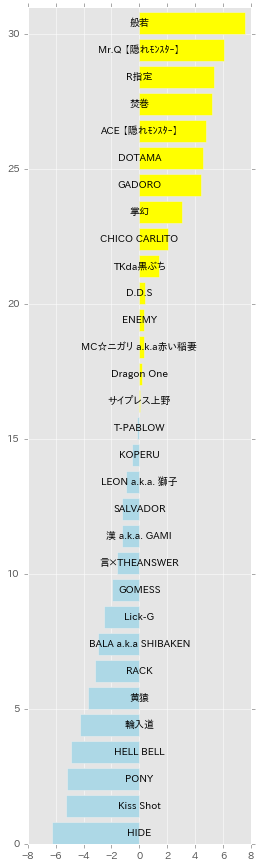

In [14]:
df = (df_ratings
      .sort_values(by='massey', ascending=True)
      .assign(color = lambda d: np.where(d.massey >= 0, 'yellow', 'lightblue')))

x = range(df.shape[0])

plt.figure(num=None, figsize=(4, 15))
plt.barh(x, width=df.massey.values, color=df.color)
plt.ylim((0, 31))

for i, xi in enumerate(x):
    plt.text(0, xi+0.3, df.index[i], horizontalalignment='center')

In [15]:
%load_ext version_information
%version_information numpy, pandas, bs4, requests

Software versions
Python 3.5.1 64bit [GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
IPython 4.0.1
OS Linux 3.19.0 49 generic x86_64 with debian jessie sid
numpy 1.10.1
pandas 0.17.1
bs4 4.4.1
requests 2.8.1
Sat Mar 05 17:30:26 2016 JST